## Trajectory Optimization of a Skateboard Model
### Phase 1: Pre-pop

<img src = "images/skateboard_phase1.png" width = "300">

In [140]:
# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

In [141]:
# DERIVE EOMS OF BOARD --------------------------------------------------------------------------------------------------------

# create symbolic variables

# system parameters
g = sym.symbols('g')
mb = sym.symbols('m_{board}') # mass
lb = sym.symbols('l_{board}') # length
lbr = sym.symbols('l_{wheels}') # length to reaction forces
hb = sym.symbols('h_{board}') # height - board clearance
Inb = sym.symbols('In_{board}') # moment of intertia

# generalized coordinates
x,y,thb = sym.symbols(['x','y','\\theta_{board}']) 
dx,dy,dthb = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{board}']) 
ddx,ddy,ddthb = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{board}']) 

q = sym.Matrix([[x],[y],[thb]])
dq = sym.Matrix([[dx],[dy],[dthb]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb]])

#display(ddq)

# forces
GRF_BB,GRF_BW,GRF_FW = sym.symbols(['GRF_{BB}','GRF_{BW}','GRF_{FW}']) # ground reaction forces
F_FF,F_BF = sym.symbols(['F_{FF}','F_{BF}']) # front and back foot applied forces

# STEP 1: position vectors ri = [x,y,theta] (world frame)
rb = sym.Matrix([[x],
                [y]])
# the Jacobians
Jb = rb.jacobian(q)

# STEP 2: generate expressions for the system space velocities from the jacobians
vb = Jb*dq

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([mb,mb])

T = 0.5*sym.transpose(Mb)*sym.matrix_multiply_elementwise(vb,vb)
T = T[0] + 0.5*Inb*dthb**2
V = mb*g*rb[1]

# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# STEP 5: generalized forces -----------------------------------------------------------------------------------------------

# applied forces
F_bf = sym.Matrix([[0],[-F_BF]])
F_ff = sym.Matrix([[0],[-F_FF]])

# ground forces acting on the board
GRF_bw = sym.Matrix([[0],[GRF_BW]])

# distance of forces
rGRF_bw = sym.Matrix([[x - 0.5*lbr*sym.cos(thb)+hb*sym.sin(thb)],
                      [y - 0.5*lbr*sym.sin(thb)-hb*sym.cos(thb)]])

rF_bf = sym.Matrix([[x - 0.5*lb*sym.cos(thb)],
                    [y - 0.5*lb*sym.sin(thb)]])

rF_ff = sym.Matrix([[x + 0.5*lbr*sym.cos(thb)],
                    [y + 0.5*lbr*sym.sin(thb)]])

JGRF_bw = rGRF_bw.jacobian(q)
JF_bf = rF_bf.jacobian(q)
JF_ff = rF_ff.jacobian(q)

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Q[j] = GRF_bw.transpose()*JGRF_bw[:,j]+F_bf.transpose()*JF_bf[:,j]+F_ff.transpose()*JF_ff[:,j]

# Calculate equations of motion
EOM = Lg1 - Lg3 + Lg4 - Q

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
     EOMs[j] = EOM[j].simplify()

display(sym.solve(EOMs,ddx))
display(sym.solve(EOMs,ddy))
display(sym.solve(EOMs,ddthb))

In [142]:
# # Something is going with Lagrange, so I'm going to solve the dynamics using Newton's laws

# # import libraries
# import sympy as sym
# import numpy as np

# sym.init_printing()
# from IPython.display import display #for pretty printing

# # system parameters
# g = sym.symbols('g')
# mb = sym.symbols('m_{board}') # mass of board
# lb = sym.symbols('l_{board}') # length of board
# lbr = sym.symbols('l_{wheels}') # length to reaction forces
# hb = sym.symbols('h_{board}') # height - board clearance
# Inb = sym.symbols('In_{board}') # moment of intertia

# # generalized coordinates
# x,y,thb = sym.symbols(['x','y','\\theta_{board}']) 
# dx,dy,dthb = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{board}']) 
# ddx,ddy,ddthb = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{board}']) 

# q = sym.Matrix([[x],[y],[thb]])
# dq = sym.Matrix([[dx],[dy],[dthb]])
# ddq = sym.Matrix([[ddx],[ddy],[ddthb]])

# # forces
# F_FF,F_BF = sym.symbols(['F_{FF}','F_{BF}']) # front and back foot applied forces
# GRF_BW = sym.symbols('GRF_{BW}') # back wheel reaction force

# EOMx = mb*ddx
# EOMy = mb*ddy - GRF_BW + mb*g + F_BF + F_FF

# l_temp = 0.5*lb+0.5*lbr

# EOMthb = Inb*ddthb - F_BF*l_temp*sym.cos(thb)+mb*g*0.5*lbr*sym.cos(thb)+F_FF*lbr*sym.cos(thb)

# EOMs = sym.Matrix([[EOMx],[EOMy],[EOMthb]])

# display(sym.solve(EOMs, ddx))
# display(sym.solve(EOMs, ddy))
# display(sym.solve(EOMs, ddthb))


In [143]:
# Simulate Dynamics -----------------------------------------------------------------------------------------------------------
#initial conditions
x0 = 0
y0 = 0.11
thb0 = 0.0
dx0 = 0
dy0 = 0
dthb0 = 0

h = 0.02

#parameters
gval = 9.81
lbval = 0.84
lbrval = 0.48
mbval = 2.0
Inbval = 1/12*mbval*lbval**2+mbval*(0.5*lbrval)**2
F_FFval = 0.0
F_BFval = 0.0
GRF_BWval = mbval*gval
GRF_FWval = 0
hbval = 0.11

parameter_values = [(g,gval),(mb,mbval),(lb,lbval),(lbr,lbrval),(Inb,Inbval),(F_BF,F_BFval),(F_FF,F_FFval),(hb,hbval),(GRF_BW,GRF_BWval),(GRF_FW,GRF_FWval)]

xar = [x0]
yar = [y0]
thar = [thb0]
dxar = [dx0]
dyar = [dy0]
dthar = [dthb0]

N = 50
for i in range(1,N):

    # substitute parameter values and previous conditions into the EOM 
    past = [(q[0],xar[i-1]),(q[1],yar[i-1]),(q[2],thar[i-1]),(dq[0],dxar[i-1]),(dq[1],dyar[i-1]),(dq[2],dthar[i-1])]
    EOM_sub = EOM.subs(parameter_values).subs(past)
    
    # solve for the acceleration
    acc = sym.solve(EOM_sub, [ddq[0],ddq[1],ddq[2]])
    
    # integrate for the next velocity and position    
    dxar.append(float(dxar[i-1]+h*acc[ddq[0]]))
    dyar.append(float(dyar[i-1]+h*acc[ddq[1]]))
    dthar.append(float(dthar[i-1]+h*acc[ddq[2]]))
    xar.append(float(xar[i-1]+h*dxar[i]))
    yar.append(float(yar[i-1]+h*dyar[i]))
    thar.append(float(thar[i-1]+h*dthar[i]))


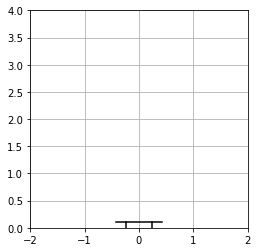

In [144]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
fig1.gca().set_aspect('equal', adjustable='box') #make x,y scales equal

def plot_board(i,x_in,y_in,th_in,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-2,2])
    ax.set_ylim([0,4])
    ax.grid()
    
    #plot skateboard
    boardLx = x_in[i]-0.5*lbval*np.cos(th_in[i])
    boardLy = y_in[i]-0.5*lbval*np.sin(th_in[i])
    boardRx = x_in[i]+0.5*lbval*np.cos(th_in[i])
    boardRy = y_in[i]+0.5*lbval*np.sin(th_in[i])
    ax.plot([boardLx,boardRx],[boardLy,boardRy],color='xkcd:black')
    
    #plot left wheel
    leftwheelTopx = x_in[i]-0.5*lbrval*np.cos(th_in[i])
    leftwheelTopy = y_in[i]-0.5*lbrval*np.sin(th_in[i])
    leftwheelBottomx = leftwheelTopx + hbval*np.sin(th_in[i])
    leftwheelBottomy = leftwheelTopy - hbval*np.cos(th_in[i])
    ax.plot([leftwheelTopx,leftwheelBottomx],[leftwheelTopy,leftwheelBottomy],color='xkcd:black')
    
    #plot right wheel
    rightwheelTopx = x_in[i]+0.5*lbrval*np.cos(th_in[i])
    rightwheelTopy = y_in[i]+0.5*lbrval*np.sin(th_in[i])
    rightwheelBottomx = rightwheelTopx + hbval*np.sin(th_in[i])
    rightwheelBottomy = rightwheelTopy - hbval*np.cos(th_in[i])
    ax.plot([rightwheelTopx,rightwheelBottomx],[rightwheelTopy,rightwheelBottomy],color='xkcd:black')
    
update = lambda i: plot_board(i,xar,yar,thar,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(N),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [145]:
# Lambdify EOMs
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,lb,lbr,Inb,hb,
            x,y,thb,
            dx,dy,dthb,
            ddx,ddy,ddthb,
            F_BF,F_FF,GRF_BB,GRF_BW,GRF_FW]
            
lambEOMx = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOMy = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOMthb = sym.lambdify(sym_list,EOMs[2],modules = [func_map])

In [255]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 20
m.N = RangeSet(N)

DOFs = ['x','y','thb'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

Fs = ['BF','FF'] # front foot, backfoot
m.Fs = Set(initialize = Fs) 

GRFs = ['BB','BW','FW'] # front foot, backfoot
m.GRFs = Set(initialize = GRFs) 

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81) # gravity
m.mb = Param(initialize = 1.0) # mass of board
m.lb = Param(initialize = 0.84) # length of board
m.lbr = Param(initialize = 0.48) # length between wheels
m.hb = Param(initialize = 0.11) # board clearance
m.mhuman = Param(initialize = 70.0) # human weight

#BW = m.mb.value*m.g.value # body weight used for scaling

m.Inb = Param(initialize = 1/12*m.mb*m.lb**2+m.mb*(0.5*m.lb)**2) # moment of inertia

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# forces
m.F = Var(m.N, m.Fs, bounds = (0.0, 1.5*m.g*m.mhuman)) # Force from front foot > 0
m.GRF = Var(m.N, m.GRFs, bounds = (0.0, None)) # Ground reaction force on back wheel

# auxillary variables
m.btail = Var(m.N, m.DOF) # back of board
m.bnose = Var(m.N, m.DOF) # front of board
m.backwheel = Var(m.N, m.DOF) # position of backwheel
m.frontwheel = Var(m.N, m.DOF) # position of frontwheel

def def_btail(m,n,dof):
    if dof == 'y':
        return m.btail[n, 'y'] == m.q[n,'y'] - 0.5*m.lb*sin(m.q[n,'thb']) 
    if dof == 'x':
        return m.btail[n, 'x'] == m.q[n,'x'] - 0.5*m.lb*cos(m.q[n,'thb'])
    else:
        return Constraint.Skip
m.def_btail = Constraint(m.N, m.DOF,rule = def_btail)

def def_bnose(m,n,dof):
    if dof == 'y':
        return m.bnose[n, 'y'] == m.q[n,'y'] + 0.5*m.lb*sin(m.q[n,'thb']) 
    if dof == 'x':
        return m.bnose[n, 'x'] == m.q[n,'x'] + 0.5*m.lb*cos(m.q[n,'thb'])
    else:
        return Constraint.Skip
m.def_bnose = Constraint(m.N, m.DOF,rule = def_bnose)

def def_backwheel(m,n,dof):
    if dof == 'y':
        return m.backwheel[n, 'y'] == m.q[n,'y']-0.5*m.lbr*sin(m.q[n,'thb'])-m.hb*cos(m.q[n,'thb'])
    if dof == 'x':
        return m.backwheel[n, 'x'] == m.q[n,'x']-0.5*m.lbr*cos(m.q[n,'thb'])+m.hb*sin(m.q[n,'thb'])
    else:
        return Constraint.Skip
m.def_backwheel = Constraint(m.N, m.DOF,rule = def_backwheel)

def def_frontwheel(m,n,dof):
    if dof == 'y':
        return m.frontwheel[n, 'y'] == m.q[n,'y']+0.5*m.lbr*sin(m.q[n,'thb'])-m.hb*cos(m.q[n,'thb'])
    if dof == 'x':
        return m.frontwheel[n, 'x'] == m.q[n,'x']+0.5*m.lbr*cos(m.q[n,'thb'])+m.hb*sin(m.q[n,'thb'])
    else:
        return Constraint.Skip
m.def_frontwheel = Constraint(m.N, m.DOF,rule = def_frontwheel)
    
# bound variables
for n in range(1,N+1):
    m.bnose[n,'y'].setlb(0.0)
    m.btail[n,'y'].setlb(0.0)
    m.backwheel[n,'y'].setlb(0.0)
    m.frontwheel[n,'y'].setlb(0.0)
    m.q[n,'thb'].setub(np.pi/2)
    m.q[n,'thb'].setlb(-np.pi/2)

# TIME AND INTEGRATION --------------------------------------------------------------------------------------------------------

# variable timestep
hm = 0.02 # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n-1,dof]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

# EOMs ------------------------------------------------------------------------------------------------------------------------

# sym_list = [g,mb,lb,lbr,Inb,hb,
#             x,y,thb,
#             dx,dy,dthb,
#             ddx,ddy,ddthb,
#             F_BF,F_FF,GRF_BW,GRF_FW]

#create the constraints
def EOMx(m,n): # for x
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mb, m.lb, m.lbr, m.Inb, m.hb,
               m.q[n,'x'], m.q[n,'y'], m.q[n,'thb'], 
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'thb'],
               m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'thb'],
               m.F[n,'BF'], m.F[n,'FF'], m.GRF[n,'BB'], m.GRF[n,'BW'], m.GRF[n,'FW']] 
    return lambEOMx(*var_list) == 0
m.EOMx = Constraint(m.N, rule = EOMx)

def EOMy(m,n): # for y
    var_list = [m.g, m.mb, m.lb, m.lbr, m.Inb, m.hb,
               m.q[n,'x'], m.q[n,'y'], m.q[n,'thb'], 
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'thb'],
               m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'thb'],
               m.F[n,'BF'], m.F[n,'FF'], m.GRF[n,'BB'],m.GRF[n,'BW'], m.GRF[n,'FW']] 
    return lambEOMy(*var_list) == 0
m.EOMy = Constraint(m.N, rule = EOMy)

def EOMthb(m,n): # for theta
    var_list = [m.g, m.mb, m.lb, m.lbr, m.Inb, m.hb,
               m.q[n,'x'], m.q[n,'y'], m.q[n,'thb'], 
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'thb'],
               m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'thb'],
               m.F[n,'BF'], m.F[n,'FF'], m.GRF[n,'BB'], m.GRF[n,'BW'], m.GRF[n,'FW']] 
    return lambEOMthb(*var_list) == 0
m.EOMthb = Constraint(m.N, rule = EOMthb)

# def Forces(m,n): # for forces
#     return m.g+m.F[n,'BF']+m.F[n,'FF'] == m.GRF[n,'FW']+m.GRF[n,'BW']
# m.Forces = Constraint(m.N, rule = Forces)

def BackWheel(m,n): # for fixing backwheel to the ground
    return m.backwheel[n,'y'] == 0
m.BackWheel = Constraint(m.N, rule = BackWheel)

In [256]:
# # HIGH DROP -----------------------------------------------------------------------------------------------------------------

# # initial condition
# m.q[1,'x'].value    = 0.0
# m.q[1,'y'].value    = 5.0
# m.q[1,'thb'].value  = 0.0
# m.dq[1,'x'].value   = 0.0
# m.dq[1,'y'].value   = 0.0
# m.dq[1,'thb'].value = 0.0

# for dof in DOFs:
#     m.q[1,dof].fixed  = True
#     m.dq[1,dof].fixed = True

In [257]:
# # STANDING -----------------------------------------------------------------------------------------------------------------
# # Doesn't work...
# # initial condition
# m.q[1,'x'].value    = 0.0
# m.backwheel[1,'y'].value = 0.0
# m.q[1,'thb'].value  = 0.0
# m.dq[1,'x'].value   = 0.0
# m.dq[1,'y'].value   = 0.0
# m.dq[1,'thb'].value = 0.0

# for dof in DOFs:
#     m.q[1,dof].fixed  = True
#     m.dq[1,dof].fixed = True
    
# m.backwheel[1,'y'].fixed = True
# m.q[1,'y'].fixed  = False

# # # guide

# # for n in range(1,N-1):
# #      m.GRF[n,'y'].value = m.g*m.mb

In [258]:
# PRE-POP -----------------------------------------------------------------------------------------------------------------
# Start the board at an thb == 0 and end at ytail == 0

# initial condition
m.q[1,'x'].value    = 0.0
m.backwheel[1,'y'].value = 0.0
m.q[1,'thb'].value  = 0.0
m.dq[1,'x'].value   = 0.0
m.dq[1,'y'].value   = 0.0
m.dq[1,'thb'].value = 0.0

for dof in DOFs:
    m.q[1,dof].fixed  = True
    m.dq[1,dof].fixed = True
    
m.q[1,'y'].fixed  = False
m.backwheel[1,'y'].fixed = True

# final conditions
m.btail[N,'y'].value = 0.0
m.btail[N,'y'].fixed = True
# m.F_BF[N].value = 0.0
# m.F_BF[N].fixed = True
# m.F_FF[N].value = 0.0
# m.F_FF[N].fixed = True


# # initialize
ytail_guide = np.linspace(m.hb.value,0.0,N)
for n in range(1,N-1):
    m.btail[n,'y'].value = ytail_guide[n]
    m.backwheel[n,'y'].value = 0.0
    

In [259]:
# COST FUNCTION ---------------------------------------------------------------------------------------------------------------
# minimum time and minimum reaction penalties

def CostFun(m):
    T = sum(m.h[n] for n in range(1,N+1))
    force_sum = 0
    for n in range(1,N+1):
        force_sum += m.F[n,'BF']+m.F[n,'FF']
        force_sum += m.GRF[n,'BB']+m.GRF[n,'BW']+m.GRF[n,'FW']
    return T+1000*force_sum
m.Cost = Objective(rule = CostFun)

In [260]:
# Solve -----------------------------------------------------------------------------------------------------------------------
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 300 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee = True) 

Ipopt 3.11.1: expect_infeasible_problem=yes
print_level=5
max_iter=30000
max_cpu_time=300
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     1129
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      187

Total number of variables............................:      453
                     variables with only l

  71 2.4163814e+005 2.18e+000 3.37e+006  -1.0 3.14e+002   0.5 6.68e-004 4.03e-003h  1
  72 2.4181517e+005 2.18e+000 3.21e+006  -1.0 1.21e+003   0.1 1.90e-003 1.48e-005h  1
  73 2.8903845e+005 2.16e+000 3.29e+006  -1.0 3.32e+002   0.5 6.66e-003 9.14e-003h  1
  74 8.8943638e+005 1.71e+000 8.31e+006  -1.0 4.85e+002   0.9 3.37e-005 2.09e-001h  1
  75 8.8973761e+005 1.69e+000 7.99e+006  -1.0 3.26e+001   2.2 2.56e-002 1.04e-002h  1
  76 8.8972216e+005 1.69e+000 7.94e+006  -1.0 1.53e+002   1.8 2.40e-003 4.64e-005f  1
  77 8.8972981e+005 1.69e+000 5.97e+006  -1.0 2.93e+001   2.2 1.50e-001 3.45e-004h  1
  78 8.7675910e+005 1.62e+000 6.28e+006  -1.0 1.27e+002   1.7 2.31e-003 3.95e-002f  1
  79 8.7677243e+005 1.62e+000 4.39e+006  -1.0 2.51e+001   2.1 1.74e-001 1.02e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 8.7694210e+005 1.62e+000 4.39e+006  -1.0 2.73e+001   1.7 6.86e-004 6.73e-004h  1
  81 8.8108882e+005 1.43e+000 4.62e+006  -1.0 1.02e+001   3

 159 6.6024462e+005 4.14e-004 6.26e+004  -1.0 1.54e-001   2.8 1.00e+000 5.62e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 6.5673566e+005 5.19e-004 3.99e+004  -1.0 5.02e-001   2.3 1.22e-001 3.47e-001f  1
 161 6.5584814e+005 8.77e-004 4.28e+004  -1.0 2.04e+001   1.9 6.23e-004 8.11e-003f  1
 162 6.5578491e+005 8.71e-004 5.90e+004  -1.0 7.00e-001   2.3 6.65e-001 5.95e-003f  1
 163 6.5553866e+005 8.62e-004 6.33e+004  -1.0 1.52e+000   1.8 9.74e-002 1.09e-002f  1
 164 6.5302395e+005 7.37e-004 3.55e+004  -1.0 7.90e-001   2.2 3.05e-003 2.55e-001f  1
 165 6.5290647e+005 7.13e-004 8.65e+004  -1.0 3.03e-001   2.7 1.00e+000 3.43e-002f  1
 166 6.5151879e+005 1.03e-003 7.65e+004  -1.0 1.75e+000   2.2 1.09e-001 1.17e-001f  1
 167 6.5148944e+005 1.03e-003 1.09e+005  -1.0 2.49e+000   1.7 7.82e-001 1.73e-003f  1
 168 6.4387327e+005 7.66e-004 7.53e+004  -1.0 4.46e+000   1.2 6.83e-003 2.58e-001f  1
 169 6.4347377e+005 6.27e-004 8.42e+004  -1.0 2.45e-001   2

 246 5.7079032e+005 5.37e-004 4.51e+004  -2.5 5.81e+000   0.1 2.97e-003 4.70e-001f  1
 247 5.6841976e+005 4.14e-003 1.57e+004  -2.5 1.66e+001  -0.3 5.79e-001 5.02e-001f  1
 248 5.6841261e+005 4.13e-003 1.56e+004  -2.5 4.32e+001  -0.8 7.78e-004 5.69e-004f  1
 249 5.6841208e+005 4.13e-003 1.56e+004  -2.5 8.99e+001  -1.3 2.02e-005 2.85e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 5.6841230e+005 4.13e-003 4.96e+004  -2.5 6.84e-001   1.8 1.00e+000 9.29e-004f 10
 251 5.6848360e+005 1.34e-004 2.12e+003  -2.5 2.56e-001   1.4 8.06e-001 1.00e+000h  1
 252 5.6846001e+005 1.11e-004 1.73e+004  -2.5 7.35e-001   0.9 7.34e-003 5.15e-001f  1
 253 5.6837153e+005 1.05e-004 8.26e+003  -2.5 1.23e-001   2.2 1.00e+000 7.97e-001f  1
 254 5.6821318e+005 6.54e-004 1.96e+003  -2.5 7.27e-001   1.7 1.77e-001 3.41e-001f  1
 255 5.6820870e+005 6.36e-004 2.74e+004  -2.5 2.15e-001   2.2 7.46e-001 2.79e-002f  1
 256 5.6820966e+005 6.28e-004 3.42e+004  -2.5 1.78e-001   1

 333r5.6663412e+005 3.26e-005 1.02e+003  -2.5 1.76e+000    -  9.89e-001 5.69e-002f  1
 334r5.6759183e+005 8.61e-005 2.71e+002  -2.5 2.33e-001    -  9.69e-001 6.73e-001f  1
 335r5.9537146e+005 1.62e-003 6.92e+001  -2.5 3.46e+000    -  9.26e-001 7.43e-001f  1
 336r6.0323893e+005 5.34e-004 1.12e-001  -2.5 1.94e+000    -  1.00e+000 1.00e+000f  1
 337r5.8593076e+005 1.41e-004 1.61e+000  -3.8 2.13e+000    -  8.78e-001 1.00e+000f  1
 338r5.8497106e+005 4.84e-006 1.89e-002  -3.8 1.27e-001    -  1.00e+000 1.00e+000h  1
 339r5.8301027e+005 1.81e-005 3.57e-004  -3.8 2.48e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340r5.7507876e+005 3.69e-005 1.35e+000  -5.7 1.06e+000    -  8.68e-001 9.93e-001f  1
 341r5.7468107e+005 3.59e-007 8.12e+001  -5.7 4.63e-002    -  8.76e-001 1.00e+000h  1
 342 5.7415382e+005 2.76e-006 3.55e+003  -2.5 3.73e+003    -  1.40e-002 4.99e-005f  1
 343 5.6901491e+005 2.17e-004 4.93e+003  -2.5 1.85e+002    

 420 5.5989113e+005 3.68e-005 2.19e+001  -2.5 7.84e-002   2.4 1.00e+000 1.00e+000f  1
 421 5.5987680e+005 7.68e-006 6.01e+002  -2.5 3.15e-002   2.9 8.08e-001 1.00e+000f  1
 422 5.5987518e+005 7.71e-006 2.69e+003  -2.5 1.36e-001   2.4 1.00e+000 1.87e-002f  1
 423 5.5989479e+005 2.95e-005 2.31e+003  -2.5 2.92e-001   1.9 1.42e-001 1.42e-001s 20
 424 5.5992826e+005 6.90e-005 1.59e+001  -2.5 7.18e-002   2.3 1.00e+000 1.00e+000s 20
 425r5.5992826e+005 6.90e-005 1.00e+003  -2.5 0.00e+000   1.9 0.00e+000 0.00e+000R  1
 426r5.5990285e+005 1.42e-005 5.71e+002  -2.5 3.99e-001    -  9.90e-001 4.15e-002f  1
 427r5.6023018e+005 3.06e-005 7.25e+001  -2.5 2.12e-001    -  8.98e-001 1.00e+000f  1
 428r5.6380958e+005 1.36e-004 3.89e+000  -2.5 4.90e-001    -  9.90e-001 1.00e+000f  1
 429r6.4942658e+005 3.94e-005 1.64e-001  -2.5 7.86e+000    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430r6.1061634e+005 8.67e-004 3.01e-002  -2.5 3.45e+000    

 508 5.5848427e+005 1.19e-004 2.63e+004  -2.5 4.93e+000    -  4.40e-002 2.63e-002f  3
 509 5.5837965e+005 1.27e-004 1.80e+005  -2.5 4.65e+000    -  7.35e-001 1.66e-002f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510 5.5377470e+005 1.14e-003 1.13e+004  -2.5 4.50e+000    -  4.30e-002 7.60e-001f  1
 511 5.5377469e+005 1.13e-003 1.08e+004  -2.5 1.96e+000   1.2 8.73e-003 3.78e-003f  2
 512 5.5379081e+005 1.11e-003 1.54e+004  -2.5 7.63e-001   1.6 1.87e-001 2.37e-002h  1
 513 5.5379238e+005 1.08e-003 8.57e+003  -2.5 1.74e+000   1.1 5.64e-004 2.71e-002h  4
 514 5.5366736e+005 9.82e-004 8.18e+003  -2.5 5.64e+000   1.5 3.05e-002 3.82e-002f  1
 515 5.5367208e+005 1.03e-003 9.30e+003  -2.5 8.70e-001   2.0 2.72e-001 2.32e-001h  1
 516 5.5367165e+005 1.03e-003 1.60e+004  -2.5 8.11e-001   1.5 5.72e-002 1.26e-003f  1
 517 5.5361183e+005 9.76e-004 1.23e+004  -2.5 2.54e+000   1.0 8.49e-005 4.77e-002f  1
 518 5.5361605e+005 9.29e-004 9.99e+003  -2.5 1.89e+000   0

 595 5.7108524e+005 2.05e-005 1.96e+004  -2.5 4.24e+001    -  1.94e-002 4.66e-006f 14
 596 5.6007651e+005 3.11e-003 1.10e+003  -2.5 2.96e+001    -  5.15e-003 5.65e-002f  1
 597 5.5954409e+005 3.07e-003 2.97e+003  -2.5 1.74e+001    -  6.91e-003 1.33e-002f  1
 598 5.5879484e+005 2.94e-003 4.55e+003  -2.5 2.35e+000   1.2 3.49e-002 4.18e-002f  1
 599 5.5873534e+005 2.93e-003 2.12e+004  -2.5 6.56e+000    -  9.65e-002 4.18e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 5.5812240e+005 2.78e-003 1.73e+005  -2.5 6.23e+000    -  6.59e-001 5.21e-002f  1
 601 5.5363260e+005 1.13e-003 4.66e+004  -2.5 5.59e+000    -  9.97e-002 5.20e-001f  1
 602 5.5361783e+005 8.65e-004 3.83e+004  -2.5 1.42e+000   1.6 9.61e-003 7.48e-002f  1
 603 5.5364082e+005 5.69e-004 4.39e+004  -2.5 4.91e-001   2.0 3.72e-001 2.25e-001h  1
 604 5.5361562e+005 3.31e-004 3.99e+004  -2.5 2.00e+000   1.5 8.98e-002 9.07e-002f  1
 605 5.5361605e+005 3.30e-004 6.66e+004  -2.5 4.11e-001   2

 682 5.6214342e+005 1.57e-004 5.49e+004  -2.5 5.05e-001   2.7 2.62e-002 2.62e-002s 17
 683 5.6215446e+005 1.56e-004 5.45e+004  -2.5 2.41e+000   2.2 8.23e-003 8.23e-003s 17
 684 5.6216349e+005 1.47e-004 5.16e+004  -2.5 5.63e-001   2.6 5.32e-002 5.32e-002s 17
 685r5.6216349e+005 1.47e-004 1.00e+003  -2.5 0.00e+000   2.1 0.00e+000 0.00e+000R  1
 686r5.6208103e+005 1.55e-004 1.05e+003  -2.5 2.83e+000    -  1.37e-001 1.92e-002f  1
 687r5.6169229e+005 1.95e-004 1.14e+003  -2.5 2.21e+000    -  9.50e-001 1.72e-001f  1
 688r5.6128749e+005 9.88e-005 9.63e+002  -2.5 1.77e+000    -  1.10e-001 3.67e-001f  1
 689 5.6127801e+005 9.88e-005 1.31e+002  -2.5 1.40e+002    -  4.12e-003 3.14e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690 5.6114435e+005 1.01e-004 1.14e+002  -2.5 1.44e+002    -  7.31e-005 5.85e-004f  4
 691 5.6092736e+005 2.85e-004 1.58e+002  -2.5 1.17e+002    -  2.46e-003 1.08e-003f  3
 692 5.6064659e+005 4.14e-004 1.28e+002  -2.5 6.44e+001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770 5.5436885e+005 2.70e-003 5.90e+004  -2.5 7.06e-001   1.2 3.32e-001 3.29e-005h  4
 771 5.5635703e+005 1.74e-003 3.18e+004  -2.5 2.57e+000    -  4.61e-001 4.61e-001s 22
 772 5.5635826e+005 1.74e-003 3.18e+004  -2.5 4.95e+000    -  3.97e-004 3.97e-004s 22
 773 5.5635958e+005 1.73e-003 3.16e+004  -2.5 7.94e-002   2.5 5.21e-003 5.21e-003s 22
 774 5.5636296e+005 1.73e-003 3.16e+004  -2.5 1.45e+000    -  1.17e-003 1.17e-003s 22
 775 5.5668778e+005 1.24e-003 2.24e+004  -2.5 4.52e-001   2.0 2.91e-001 2.91e-001s 22
 776 5.5669022e+005 1.23e-003 2.23e+004  -2.5 3.02e-001   1.5 2.59e-003 2.59e-003s 22
 777 5.5687504e+005 8.58e-004 1.56e+004  -2.5 3.62e-001   2.0 3.03e-001 3.03e-001s 22
 778 5.5707004e+005 4.84e-004 8.77e+003  -2.5 1.45e-001   2.4 4.37e-001 4.37e-001s 22
 779 5.5719858e+005 4.48e-004 8.68e+003  -2.5 1.68e+001   1.9 1.03e-002 1.03e-002s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 857 5.5558502e+005 3.11e-004 5.15e+004  -2.5 1.04e+000   2.4 5.07e-003 1.91e-002f  1
 858 5.5558500e+005 3.11e-004 1.19e+004  -2.5 2.28e-001   1.9 2.74e-001 1.24e-004f  2
 859 5.5562561e+005 3.09e-004 9.25e+003  -2.5 4.34e+000    -  3.46e-001 1.34e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860 5.5771078e+005 2.61e-004 1.62e+004  -2.5 4.38e+000    -  9.98e-001 6.72e-001h  1
 861 5.6005907e+005 3.68e-004 1.64e+002  -2.5 2.93e+000    -  7.23e-001 1.00e+000h  1
 862 5.6070784e+005 2.23e-004 8.64e+003  -2.5 1.72e+000    -  1.60e-003 4.45e-001h  1
 863 5.6078017e+005 1.83e-004 7.14e+003  -2.5 7.75e-001   2.4 1.73e-001 1.73e-001s 20
 864 5.6078798e+005 1.34e-004 5.22e+003  -2.5 1.99e-001   2.8 2.69e-001 2.69e-001s 20
 865 5.6079561e+005 1.30e-004 5.09e+003  -2.5 8.44e-001   2.3 2.47e-002 2.47e-002s 20
 866 5.6078936e+005 8.20e-005 2.67e+003  -2.5 1.91e-001   2.8 4.75e-001 4.75e-001s 20
 867 5.6078942e+005 8.23e-005 2.67e+003  -2.5 9.77e-001   2

 944 5.6074488e+005 1.98e-004 8.93e+002  -2.5 2.20e+000   2.2 6.01e-002 6.01e-002s 21
 945r5.6074488e+005 1.98e-004 1.00e+003  -2.5 0.00e+000   2.6 0.00e+000 0.00e+000R  1
 946r5.6058005e+005 8.60e-005 1.06e+003  -2.5 4.59e+000    -  1.68e-001 1.44e-002f  1
 947 5.6057820e+005 8.60e-005 1.74e+003  -2.5 1.10e+001    -  2.42e-002 6.61e-005f  1
 948 5.6033492e+005 1.21e-004 2.66e+003  -2.5 6.25e+000    -  3.50e-003 1.49e-002f  1
 949 5.5997478e+005 2.66e-004 2.58e+003  -2.5 6.20e+000    -  3.61e-002 3.26e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950 5.5940270e+005 2.49e-004 8.41e+003  -2.5 6.00e+000    -  4.13e-002 6.67e-002f  1
 951 5.5856244e+005 2.22e-004 1.29e+004  -2.5 5.32e+000    -  1.83e-001 1.12e-001f  1
 952 5.5844317e+005 1.98e-004 2.45e+004  -2.5 2.27e-001   2.2 2.46e-001 1.07e-001f  1
 953 5.5796184e+005 1.57e-004 2.27e+004  -2.5 3.54e-001   1.7 2.57e-001 4.91e-001F  1
 954 5.5772747e+005 1.89e-004 3.95e+004  -2.5 1.12e-001   2

In [261]:
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.

ok
optimal


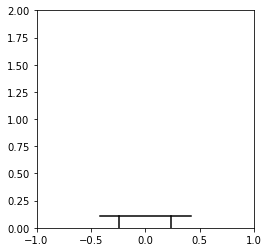

In [262]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

def plot_board(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,1])
    ax.set_ylim([0,2])
    
    #plot skateboard
    boardLx = m.btail[i,'x'].value
    boardLy = m.btail[i,'y'].value
    boardRx = m.bnose[i,'x'].value
    boardRy = m.bnose[i,'y'].value
    ax.plot([boardLx,boardRx],[boardLy,boardRy],color='xkcd:black')
    
    #plot left wheel
    leftwheelTopx = m.q[i,'x'].value-0.5*m.lbr*np.cos(m.q[i,'thb'].value)
    leftwheelTopy = m.q[i,'y'].value-0.5*m.lbr*np.sin(m.q[i,'thb'].value)
    leftwheelBottomx = m.backwheel[i,'x'].value
    leftwheelBottomy = m.backwheel[i,'y'].value
    ax.plot([leftwheelTopx,leftwheelBottomx],[leftwheelTopy,leftwheelBottomy],color='xkcd:black')
    
    #plot right wheel
    rightwheelTopx = m.q[i,'x'].value+0.5*m.lbr*np.cos(m.q[i,'thb'].value)
    rightwheelTopy = m.q[i,'y'].value+0.5*m.lbr*np.sin(m.q[i,'thb'].value)
    rightwheelBottomx = m.frontwheel[i,'x'].value
    rightwheelBottomy = m.frontwheel[i,'y'].value
    ax.plot([rightwheelTopx,rightwheelBottomx],[rightwheelTopy,rightwheelBottomy],color='xkcd:black')
    
update = lambda i: plot_board(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [264]:
m.ddq.pprint()

ddq : Size=60, Index=ddq_index
    Key         : Lower : Value                   : Upper : Fixed : Stale : Domain
     (1, 'thb') :  None :      110.57236222503369 :  None : False : False :  Reals
       (1, 'x') :  None :                     0.0 :  None : False : False :  Reals
       (1, 'y') :  None :      26.271212787704656 :  None : False : False :  Reals
     (2, 'thb') :  None :      -7.409059194089839 :  None : False : False :  Reals
       (2, 'x') :  None :                     0.0 :  None : False : False :  Reals
       (2, 'y') :  None :     -2.5491219767630935 :  None : False : False :  Reals
     (3, 'thb') :  None :      -7.164436598318854 :  None : False : False :  Reals
       (3, 'x') :  None :                     0.0 :  None : False : False :  Reals
       (3, 'y') :  None :     -2.6429586066495334 :  None : False : False :  Reals
     (4, 'thb') :  None :     -7.3609775405784035 :  None : False : False :  Reals
       (4, 'x') :  None :                     0.0 :  Non